In [1]:
!pip install pandas-datareader
!pip install keras
!pip install FundamentalAnalysis

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import FundamentalAnalysis as fa
import bs4 as bs
import pickle
import requests
from google.colab import files
from statsmodels.graphics.tsaplots import plot_acf

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


# Part 1: Technical Analysis

## Data Exploration and Setup

In [0]:
start_date = '2015-01-10'
end_date = '2020-01-10'

In [4]:
aapl_stock = pdr.DataReader('AAPL', data_source='yahoo', start = start_date, end = end_date)
aapl_stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-12,112.629997,108.800003,112.599998,109.250000,49650800.0,100.143120
2015-01-13,112.800003,108.910004,111.430000,110.220001,67091900.0,101.032280
2015-01-14,110.489998,108.500000,109.040001,109.800003,48956600.0,100.647285
2015-01-15,110.059998,106.660004,110.000000,106.820000,60014000.0,97.915672
2015-01-16,107.580002,105.199997,107.029999,105.989998,78513300.0,97.154854


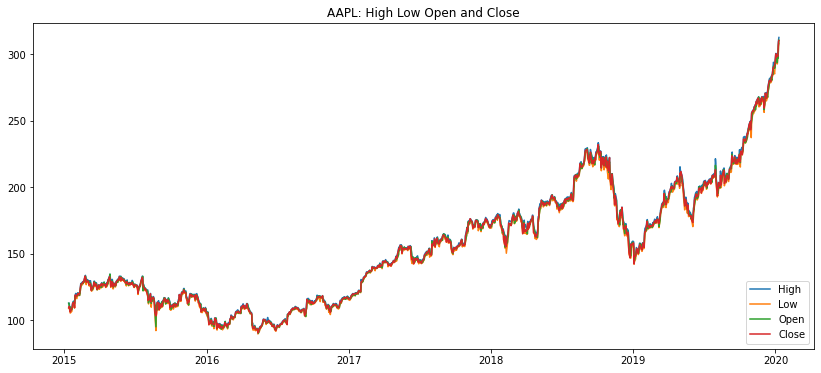

In [5]:
plt.figure(figsize=(14, 6))
plt.title("AAPL: High Low Open and Close")
plt.plot(aapl_stock[['High', 'Low', 'Open', 'Close']])
plt.legend(['High', 'Low', 'Open', 'Close'], loc='lower right')
plt.show()

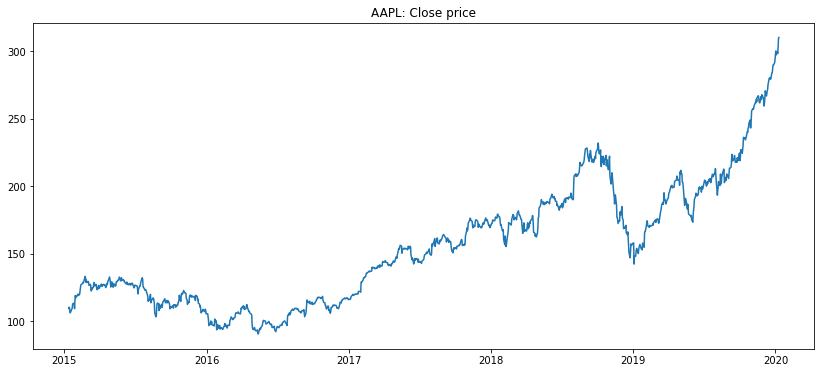

In [6]:
plt.figure(figsize=(14, 6))
plt.title("AAPL: Close price")
plt.plot(aapl_stock['Close'])
plt.show()

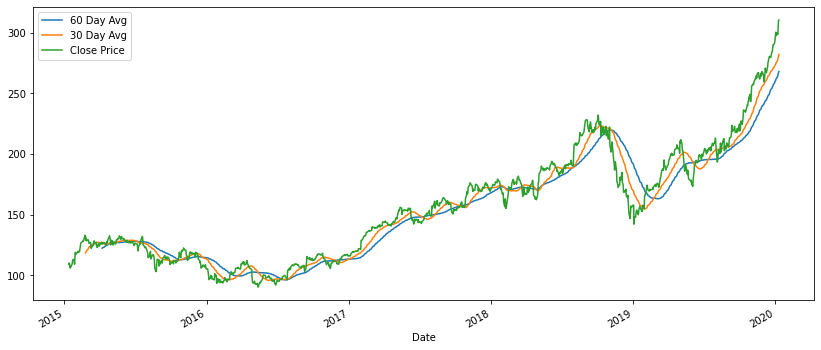

In [7]:
plt.figure(figsize=(14, 6))
aapl_stock['Close'].rolling(window=60).mean().plot(label='60 Day Avg')
aapl_stock['Close'].rolling(window=30).mean().plot(label='30 Day Avg')
aapl_stock['Close'].plot(label='Close Price')
plt.legend()
plt.show()

In [8]:
aapl_stock['Close']

Date
2015-01-12    109.250000
2015-01-13    110.220001
2015-01-14    109.800003
2015-01-15    106.820000
2015-01-16    105.989998
                 ...    
2020-01-06    299.799988
2020-01-07    298.390015
2020-01-08    303.190002
2020-01-09    309.630005
2020-01-10    310.329987
Name: Close, Length: 1259, dtype: float64

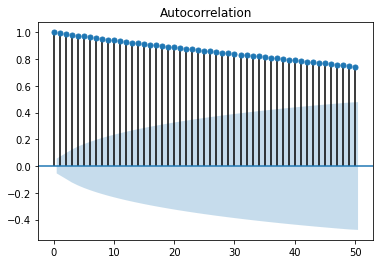

In [9]:
plot_acf(aapl_stock['Close'], lags = 50);

In [0]:
aapl_close = aapl_stock.filter(['Close'])
aapl_data = aapl_close.values

In [0]:
#Train the model on the first 80% of the data
training_data_len = math.ceil(len(aapl_data)*.8) 

#create train datasets out of 60 previous trading days
train_data = aapl_data[0:training_data_len, : ]
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [0]:
#Create test datasets
test_data = aapl_data[training_data_len - 60: , : ]
x_test = []
y_test =  []
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    y_test.append(test_data[i,0])

In [0]:
#Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

## Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
# R squared????
print(lin_reg.score(x_train, y_train))
print(lin_reg.score(x_test, y_test))

0.9962419257374365
0.9909762138877197


In [16]:
# find RMSE value
from sklearn.metrics import mean_squared_error

y_predict = lin_reg.predict(x_test)
lin_reg_mse = mean_squared_error(y_predict, y_test)
rmse = math.sqrt(lin_reg_mse)
rmse

3.4470553493885867

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


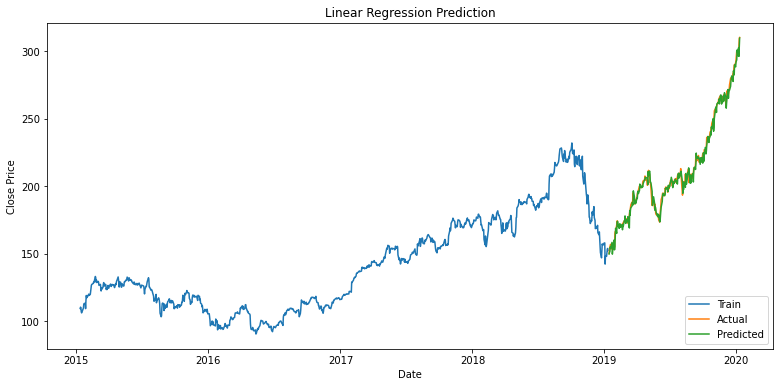

In [17]:
#Plot the graph of actual vs predicted values
train = aapl_close[:training_data_len]
valid = aapl_close[training_data_len:]
valid['Predictions'] = y_predict
plt.figure(figsize=(13,6))
plt.title('Linear Regression Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.show()

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=12, n_estimators=20, max_depth = 8) 
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=12, verbose=0, warm_start=False)

In [19]:
print(rfr.score(x_train, y_train))
print(rfr.score(x_test, y_test))

0.9989221448409453
0.5707564942744345


In [20]:
y_predict = rfr.predict(x_test)
rfr_mse = mean_squared_error(y_predict, y_test)
rmse = math.sqrt(rfr_mse)
rmse

23.77418988554176

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


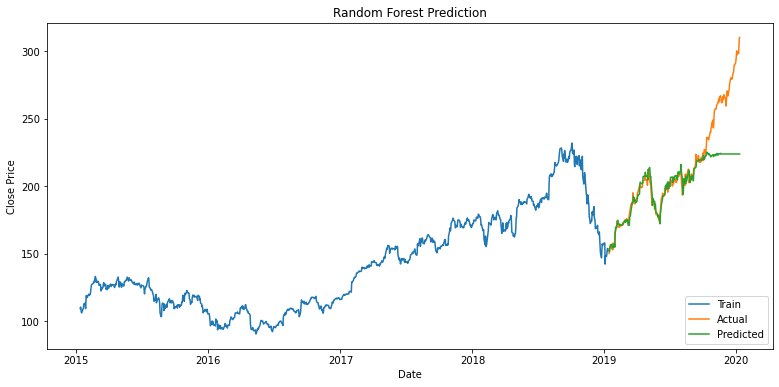

In [21]:
#Plot the graph of actual vs predicted values
train = aapl_close[:training_data_len]
valid = aapl_close[training_data_len:]
valid['Predictions'] = y_predict
plt.figure(figsize=(13,6))
plt.title('Random Forest Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.show()

##LSTM

In [0]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(aapl_data)

#Create train datasets
train_data = scaled_data[0:training_data_len  , : ]
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [0]:
#Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape the data for the LSTM model: 3D input
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [0]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
948/948 [==============================] - 31s 33ms/step - loss: 0.0017


In [0]:
#Create test datasets
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  aapl_data[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [0]:
#Convert to a numpy array 
x_test = np.array(x_test)
#Reshape the data for the LSTM model: 3D input
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [29]:
#Find predictions and RMSE
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

7.995198827369372

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


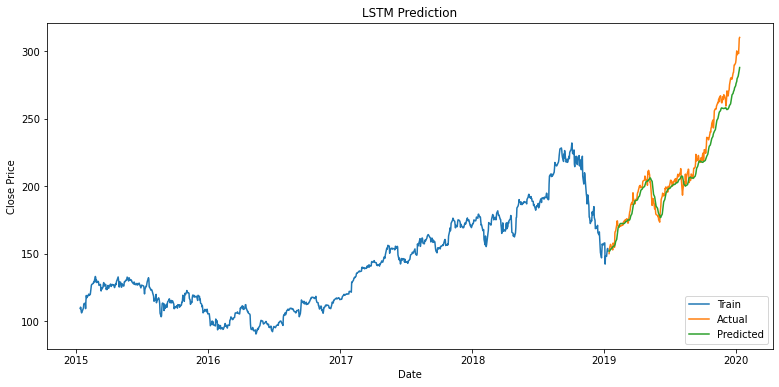

In [30]:
#Plot the graph of actual vs predicted values
train = aapl_close[:training_data_len]
valid = aapl_close[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(13,6))
plt.title('LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.show()

##Summary: analyzing multiple stocks

In [0]:
def find_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        t = row.findAll('td')[0].text
        tickers.append(t.split('\n')[0])
        
    return tickers

In [0]:
sp_tickers = find_sp500_tickers()

In [0]:
import random
random.seed(40)
r_tickers = random.sample(sp_tickers, 50)

In [0]:
start_date = '2015-01-10'
end_date = '2020-01-10'
training_data_len = math.ceil(len(aapl_data)*.8) 

In [0]:
def linearreg(x_train, y_train, x_test, y_test):
  lin_reg = LinearRegression()
  lin_reg.fit(x_train, y_train)
  score = lin_reg.score(x_test, y_test)
  y_predict = lin_reg.predict(x_test)
  lin_reg_mse = mean_squared_error(y_predict, y_test)
  rmse = math.sqrt(lin_reg_mse)
  return score, rmse

In [0]:
def rfreg(x_train, y_train, x_test, y_test):
  rfr = RandomForestRegressor(random_state=12, n_estimators=10, max_depth = 8) 
  rfr.fit(x_train, y_train)
  score = rfr.score(x_test, y_test)
  y_predict = rfr.predict(x_test)
  rmse = math.sqrt(mean_squared_error(y_predict, y_test))
  return score, rmse

In [0]:
def create_summary(tickers):
  rows_list = []
  for ticker in tickers:
    stock = pdr.DataReader(ticker, data_source='yahoo', start = start_date, end = end_date)
    stock_close = stock.filter(['Close'])
    stock_data = stock_close.values
    train_data = stock_data[0:training_data_len, : ]
    x_train=[]
    y_train = []
    for i in range(60,len(train_data)):
      x_train.append(train_data[i-60:i,0])
      y_train.append(train_data[i,0])

    test_data = stock_data[training_data_len - 60: , : ]
    x_test = []
    y_test =  []
    for i in range(60,len(test_data)):
      x_test.append(test_data[i-60:i,0])
      y_test.append(test_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    dict1 = {}
    lr_score, lr_rmse = linearreg(x_train, y_train, x_test, y_test)
    rf_score, rf_rmse = rfreg(x_train, y_train, x_test, y_test)
    dict1['stock'] = ticker
    dict1['LinearRegScore'] = lr_score
    dict1['LinearRegRMSE'] = lr_rmse
    dict1['RandomForestScore'] = rf_score
    dict1['RandomForestRMSE'] = rf_rmse
    rows_list.append(dict1)

  return rows_list

In [0]:
r_tickers.remove("OTIS")
r_tickers.remove('CARR')

In [0]:
# Takes a long time
summary = create_summary(r_tickers)

In [0]:
summary_df = pd.DataFrame(summary)

In [41]:
summary_df.head()

,stock,LinearRegScore,LinearRegRMSE,RandomForestScore,RandomForestRMSE
0,HFC,0.949189,1.014729,0.933848,1.157827
1,LKQ,0.980041,0.498055,0.962609,0.681692
2,TDG,0.978018,8.272288,-5.303245,140.079462
3,JNJ,0.909834,1.499712,0.900462,1.575727
4,ARE,0.975040,1.488978,-3.578099,20.165586


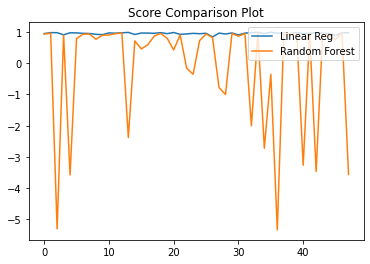

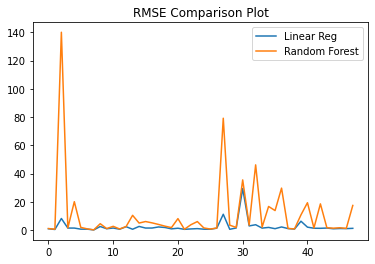

In [42]:
plt.plot(summary_df['LinearRegScore'])
plt.plot(summary_df['RandomForestScore'])
plt.title("Score Comparison Plot")
plt.legend(['Linear Reg', 'Random Forest'], loc='upper right')
plt.show()
plt.plot(summary_df['LinearRegRMSE'])
plt.plot(summary_df['RandomForestRMSE'])
plt.title("RMSE Comparison Plot")
plt.legend(['Linear Reg', 'Random Forest'], loc='upper right')
plt.show()

## Extra: Time Series with Prophet

In [0]:
#Maybe: rerun
start_date = '2015-01-10'
end_date = '2020-01-10'
aapl_stock = pdr.DataReader('AAPL', data_source='yahoo', start = start_date, end = end_date)

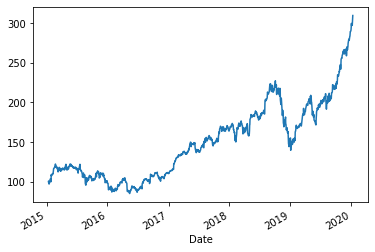

In [44]:
aapl_stock['Adj Close'].plot()

In [0]:
aapl_stock = aapl_stock.reset_index().rename(columns={'Date':'ds', 'Adj Close':'y'})

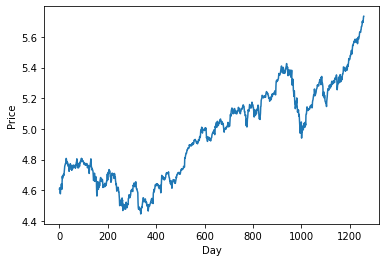

In [46]:
# Log Transform Data
aapl_stock['y'] = pd.DataFrame(np.log(aapl_stock['y']))

# plot data
plt.plot(aapl_stock['y'])
plt.ylabel('Price')
plt.xlabel('Day')
plt.show()

In [0]:
training_data_len = math.ceil(len(aapl_stock) *.90) 
df_train = aapl_stock[:training_data_len]
df_test = aapl_stock[training_data_len:]

In [48]:
from fbprophet import Prophet

pmodel = Prophet(interval_width=0.95, daily_seasonality=True)
pmodel.fit(df_train)
future = pmodel.make_future_dataframe(periods=125, freq='MS')

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [0]:
forecast = pmodel.predict(future)

In [50]:
# retransform using e
y_hat = np.exp(forecast['yhat'][training_data_len:])
y_true = np.exp(aapl_stock['y'])
 
# compute the mean square error
rmse = math.sqrt(((y_hat - y_true) ** 2).mean())
rmse

55.821544603260705

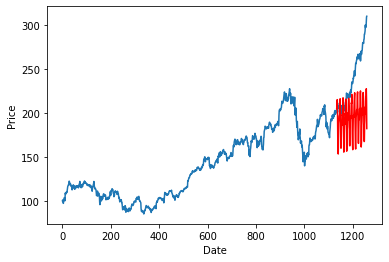

In [51]:
plt.plot(y_true, label='Original');
plt.plot(y_hat, color='r', label='Forecast');
plt.ylabel('Price');
plt.xlabel('Date');
plt.show()

#Part 2: Fundamental Analysis

**Warning**: the regression models do not give out useful results. The classification models give considerably accurate results when given high threshold value, but the true positive rate is very low (not much better than random). Although the findings might not be applicable for now, I chose to this part for the project because I believe this can lead to effective modifications or further research.

## Data Setup

In [0]:
sp_tickers = find_sp500_tickers()

In [0]:
tickers_all = sp_tickers
tickers_all.remove('CARR')
tickers_all.remove('J')
tickers_all.remove('OTIS')
tickers_all.remove('TFC')
tickers_all.remove('BRK.B')
tickers_all.remove('BF.B')

In [0]:
fundamentals = ['Market Cap', 'PE ratio', 
       'Enterprise Value over EBITDA', 'Earnings Yield', 
       'Debt to Equity', 'Net Debt to EBITDA',
       'Current ratio', 'Income Quality','Dividend Yield', 'Payout Ratio', 
       'SG&A to Revenue', 'R&D to Revenue', 'Capex to Revenue',
       'Stock-based compensation to Revenue', 'Working Capital',
       'Net Current Asset Value']

In [0]:
def get_fundamentals(tickers_all):
  for ticker in tickers_all:
    metrics_df = fa.key_metrics(ticker, period="quarter")
    metrics_dft = metrics_df.T
    metrics_fea = metrics_dft[fundamentals]
    funda_df = metrics_fea.reset_index()
    funda_df['index'] = pd.to_datetime(funda_df['index']) 
    funda_df.rename(columns={'index':'date'}, inplace =True)
    funda_df['ticker'] = ticker
    funda_df.dropna(axis=0, inplace=True)
    if (ticker == tickers_all[0]):
      funda_total = funda_df
    else:
      funda_total = funda_total.append(funda_df, ignore_index = True)
  
  colname = list(funda_total)
  colname.remove('ticker')
  colname.remove('date')

  funda_total[colname] = funda_total[colname].apply(pd.to_numeric, errors= 'coerce')
  return funda_total

In [0]:
# This takes quite a long time
funda_to_merge = get_fundamentals(tickers_all)

In [0]:
#get SP500 return for each quarter
sp_df = fa.stock_data('^GSPC', start="2010-03-01", end="2019-12-02", interval = "3mo")
sp_df = sp_df.reset_index()
sp_df['index'] = pd.to_datetime(sp_df['index'])
sp_df.rename(columns={'index':'date'}, inplace =True)
sp_df['close2'] = sp_df['close'].shift(-1)
sp_df['sp500change'] = (sp_df['close2']-sp_df['close'])*100/sp_df['close']
sp_df = sp_df[['date','sp500change']]

In [0]:
#create price_to_merge which is a dataframe of each stock return in each quarter
for ticker in tickers_all:
  qprice = fa.stock_data(ticker, start="2010-03-01", end="2019-12-02", interval = "3mo")
  qprice = qprice.reset_index()
  qprice = qprice[['index','close']]
  qprice['index'] = pd.to_datetime(qprice['index'])
  qprice.rename(columns={'index':'date'}, inplace =True)
  qprice['close2'] = qprice['close'].shift(-1)
  qprice['price change'] = (qprice['close2']-qprice['close'])*100/qprice['close']
  qprice['ticker'] = ticker
  if (ticker == tickers_all[0]):
    price_to_merge = qprice
  else:
    price_to_merge = price_to_merge.append(qprice, ignore_index = True)

In [0]:
# merging price_to_merge with the sp500 return of that quarter
price_sp_merged = price_to_merge.merge(sp_df, how='left', on = 'date')

In [0]:
price_sp_merged['outperform_percent'] = price_sp_merged['price change'] - price_sp_merged['sp500change']

In [0]:
#merging fundamentals and price with sp500 dataframes BIG
merged_df = funda_to_merge.merge(price_sp_merged, left_on = ['date','ticker'], right_on=['date','ticker'])
merged_df.dropna(axis=0, inplace=True)

In [0]:
#delete rows with extreme values
merged_df = merged_df[merged_df['outperform_percent']<40]
merged_df = merged_df[merged_df['outperform_percent']>-40]

##Regression

In [0]:
from sklearn.model_selection import train_test_split
col_notx = ['date', 'ticker','close','close2','price change','sp500change','outperform_percent']
x_train, x_test, y_train, y_test = train_test_split(merged_df.drop(col_notx, axis=1),
                                                    merged_df['outperform_percent'], test_size=0.2, random_state=122)

### Linear Regression

In [90]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [91]:
print(lin_reg.score(x_train, y_train))
print(lin_reg.score(x_test, y_test))

0.0017750413411428134
-0.0022917485346303224


In [92]:
from sklearn.metrics import mean_squared_error

y_predict = lin_reg.predict(x_test)
lin_reg_mse = mean_squared_error(y_predict, y_test)
rmse = math.sqrt(lin_reg_mse)
rmse

10.558045655699837

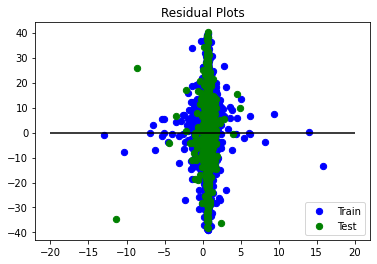

In [93]:
# Plotting Residuals
plt.scatter(lin_reg.predict(x_train), lin_reg.predict(x_train)-y_train, c='b',s=40)
plt.scatter(lin_reg.predict(x_test), lin_reg.predict(x_test)-y_test, c='g',s=40,)
plt.hlines(y=0,xmin=-20,xmax=20)
plt.title("Residual Plots")
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

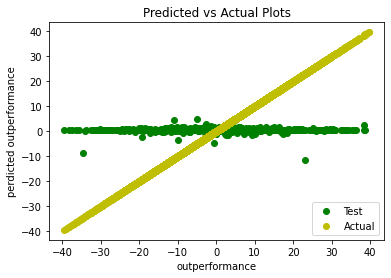

In [94]:
plt.scatter(y_test, y_predict, c= 'g')
plt.scatter(merged_df['outperform_percent'], merged_df['outperform_percent'], c='y')
plt.xlabel('outperformance')
plt.ylabel('perdicted outperformance')
plt.title("Predicted vs Actual Plots")
plt.legend(['Test', 'Actual'], loc='lower right')
plt.show()

PCA with Linear Regression

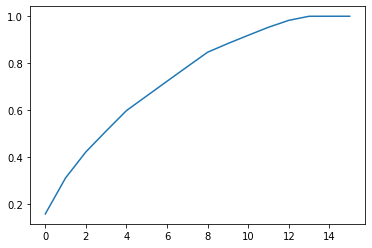

In [95]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
x_train_t = StandardScaler().fit_transform(x_train)
x_test_t = StandardScaler().fit_transform(x_test)
pca = PCA(n_components = 16)
pca = pca.fit(x_train_t)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [0]:
pca = PCA(n_components=12)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [97]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [98]:
print(lin_reg.score(x_train, y_train))
print(lin_reg.score(x_test, y_test))

0.0012291080020602196
9.069147581075576e-05


In [99]:
y_predict = lin_reg.predict(x_test)
lin_reg_mse = mean_squared_error(y_predict, y_test)
rmse = math.sqrt(lin_reg_mse)
rmse

10.545489992194161

Lasso (also very bad)

In [100]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=0.5)
model_lasso.fit(x_train, y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [101]:
print(lin_reg.score(x_train, y_train))
print(lin_reg.score(x_test, y_test))

pred_train_lasso= model_lasso.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))

pred_test_lasso= model_lasso.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 

0.0012291080020602196
9.069147581075576e-05
10.5013503074467
10.545654458973493


### Random Forest

In [102]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=12, n_estimators=20, max_depth = 20)
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=12, verbose=0, warm_start=False)

In [103]:
print(rfr.score(x_train, y_train))
print(rfr.score(x_test, y_test))

0.5874985151702214
-0.0363304981309267


In [104]:
y_predict = rfr.predict(x_test)
rfr_mse = mean_squared_error(y_predict, y_test)
rmse = math.sqrt(rfr_mse)
rmse

10.7358293042994

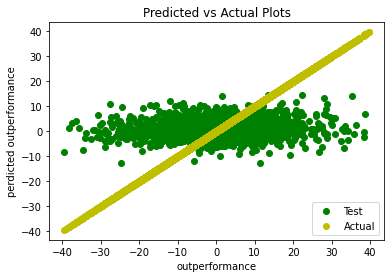

In [105]:
plt.scatter(y_test, y_predict, c= 'g')
plt.scatter(merged_df['outperform_percent'], merged_df['outperform_percent'], c='y')
plt.xlabel('outperformance')
plt.ylabel('perdicted outperformance')
plt.title("Predicted vs Actual Plots")
plt.legend(['Test', 'Actual'], loc='lower right')
plt.show()

### try LSTM (not included in actual one)

In [106]:
#Scale the all of the data to be values between 0 and 1 
x_scaler = MinMaxScaler() 
y_scaler = MinMaxScaler() 
scaled_x = merged_df.drop(col_notx, axis = 1)
scaled_x[scaled_x.columns] = x_scaler.fit_transform(scaled_x[scaled_x.columns])

scaled_y = merged_df[['outperform_percent']]
scaled_y[scaled_y.columns] = y_scaler.fit_transform(scaled_y[scaled_y.columns])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2969: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2935: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
x_train, x_test, y_train, y_test = train_test_split(scaled_x, scaled_y, 
                                                    test_size=0.2, random_state=42)

In [0]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [0]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [111]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
10982/10982 [==============================] - 101s 9ms/step - loss: 0.0181


In [0]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
predictions = model.predict(x_test) 
predictions = y_scaler.inverse_transform(predictions)
y_test_orig = y_scaler.inverse_transform(y_test)

In [113]:
rmse=np.sqrt(np.mean(((predictions- y_test_orig)**2)))
rmse

10.699994172949529

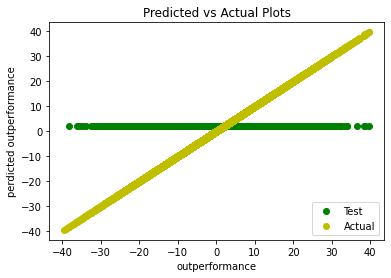

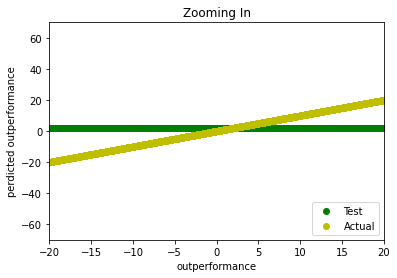

In [114]:
plt.scatter(y_test_orig, predictions, c= 'g')
plt.scatter(merged_df['outperform_percent'], merged_df['outperform_percent'], c='y')
plt.xlabel('outperformance')
plt.ylabel('perdicted outperformance')
plt.title("Predicted vs Actual Plots")
plt.legend(['Test', 'Actual'], loc='lower right')
plt.show()
plt.scatter(y_test_orig, predictions, c= 'g')
plt.scatter(merged_df['outperform_percent'], merged_df['outperform_percent'], c='y')
plt.xlabel('outperformance')
plt.ylabel('perdicted outperformance')
plt.title("Predicted vs Actual Plots")
plt.xlim(-20,20)
plt.ylim(-70,70)
plt.title("Zooming In")
plt.legend(['Test', 'Actual'], loc='lower right')
plt.show()

## Classification

In [116]:
perfomance_threshold = 10
sum(merged_df['outperform_percent']>perfomance_threshold)

2235

In [117]:
# % of data with values 1
sum(merged_df['outperform_percent']>perfomance_threshold)/len(merged_df['outperform_percent'])

0.16280594405594406

In [0]:
merged_df['significant_perform'] = merged_df['outperform_percent']>perfomance_threshold

In [0]:
from sklearn.model_selection import train_test_split
col_notx = ['date', 'ticker','close','close2','price change','sp500change','outperform_percent','significant_perform']
x_train, x_test, y_train, y_test = train_test_split(merged_df.drop(col_notx, axis=1),
                                                    merged_df['significant_perform'], test_size=0.2, random_state=22)

### Logistic Regression

In [120]:
from sklearn.linear_model import LogisticRegression

lin_reg = LogisticRegression()
lin_reg.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [121]:
print(lin_reg.score(x_train, y_train))
print(lin_reg.score(x_test, y_test))

0.8339100346020761
0.8503277494537509


In [122]:
from sklearn.metrics import confusion_matrix

y_predict = lin_reg.predict(x_test)
cma = confusion_matrix(y_test, y_predict)
cma

array([[2335,    0],
       [ 411,    0]])

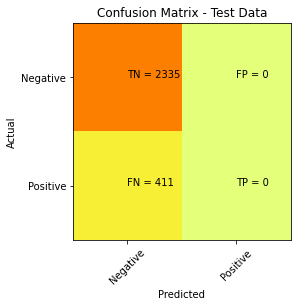

In [123]:
plt.clf()
plt.imshow(cma, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('Actual')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cma[i][j]))
plt.show()

### Random Forest

In [124]:
from sklearn.ensemble import RandomForestClassifier
rfr = RandomForestClassifier(random_state=12, n_estimators=20, max_depth = 20)
rfr.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

In [125]:
print(rfr.score(x_train, y_train))
print(rfr.score(x_test, y_test))

0.9574758696048079
0.8455935906773488


In [126]:
y_predict = rfr.predict(x_test)
cma = confusion_matrix(y_test, y_predict)
cma

array([[2303,   32],
       [ 392,   19]])

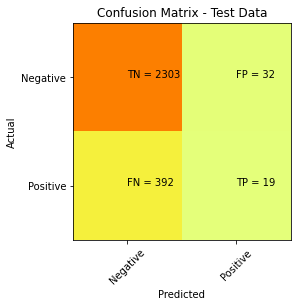

In [127]:
plt.clf()
plt.imshow(cma, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('Actual')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cma[i][j]))
plt.show()

0.5162621068371392


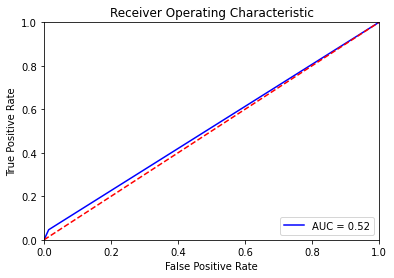

In [128]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predict)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()